In [5]:
import matplotlib
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pickle
from collections import Counter
from util import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ratings, movies, genres = read_files()
with open('plot_data.pickle', 'rb') as handle:
    plot_data = pickle.load(handle)
ratings.head(),None, movies.head()


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
 None,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  Crime  Western  Film-Noir  \
 0  Adventure|Animation|Children|Comedy|Fantasy  False    False      False   
 1                   Adventure|Children|Fantasy  False    False      False   
 2                               Comedy|Romance  False    False      False   
 3                         Comedy|Drama|Romance  False    False      False   
 4                                       Comedy  False    Fa

# Macierz użyteczności

Ocena filmu przez użytkownika

In [3]:
utility_matrix = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId']))).asfptype()
utility_matrix.toarray(), utility_matrix.toarray().shape

(array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 4. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 2.5, 2. , ..., 0. , 0. , 0. ],
        [0. , 3. , 0. , ..., 0. , 0. , 0. ],
        [0. , 5. , 0. , ..., 0. , 0. , 0. ]]), (611, 193610))

In [4]:
Tree_data = pd.DataFrame(
        data=utility_matrix.toarray()[:, movies["movieId"]].T,
        # index=movies["movieId"],
        columns=[f"user_{x}" for x in range(utility_matrix.shape[0])]

)
# movies.shape, utility_matrix.toarray()[:, movies["movieId"]].T.shape
# print(Tree_data.shape, movies[list(genres)].shape, movies["mean"].shape)
Tree_data[list(genres)] = movies[list(genres)]
Tree_data['mean'] = movies['mean']
Tree_data = Tree_data.fillna(0)
Tree_data.head()

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,...,Mystery,Musical,Animation,Documentary,Fantasy,Children,Action,Horror,Thriller,mean
0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,...,False,False,True,False,True,True,False,False,False,3.920930
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,...,False,False,False,False,True,True,False,False,False,3.431818
2,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,3.259615
3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,2.357143
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,3.071429


In [ ]:
tmp_genres = list(genres)
# tmp_genres = ["Drama", "Comedy", "Action", "Documentary"]
# axs = plt.subplots(figsize=(15, 15))
axs = None
plot_data["DecisionTreeClassifier"] = test_classifier(
        tree.DecisionTreeClassifier,
        Tree_data,
        tmp_genres,
        axs=axs,
        verbose=False,
        plot=False,
        max_depth=30, 
        min_samples_split=20, 
        min_samples_leaf=10, 
        min_impurity_decrease=0.0001,
        n_jobs=-1,
        class_weight='balanced'
)
with open('plot_data.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

for i in [5, 10, 50, 100]:
    name = f"RandomForest_max_depth_{i}"
    plot_data[name]=test_classifier(
            RandomForestClassifier,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=i,
            random_state=7,
            max_features=5,
            n_estimators=100,
            n_jobs=-1,
            class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



for i in tqdm([10, 50, 100, 500, 1000]):
    name = f"RandomForest_n_estimators_{i}"
    plot_data[name]=test_classifier(
            RandomForestClassifier,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=9,
            n_estimators=i,
            n_jobs=-1,
            class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
for i in tqdm([7, 8, 9, 10, 11, 15, 20, 50]):
    name = f"RandomForest_max_features_{i}"
    plot_data[name]=test_classifier(
            RandomForestClassifier,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=i,
            n_jobs=-1,
            n_estimators=100,
            class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
tmp_genres = list(genres)
name = f"RandomForest_max_features_20_n_estimators_100_max_depth_50"
plot_data[name]=test_classifier(
        RandomForestClassifier,
        Tree_data,
        tmp_genres,
        clf_name=name,
        axs=axs,
        verbose=False,
        plot=False,
        max_depth=50,
        random_state=7,
        max_features=20,
        n_jobs=-1,
        n_estimators=100,
        class_weight="balanced"
)
with open('plot_data.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



RandomForest_max_depth_5
RandomForest_max_depth_10
Counter({'RandomForest_max_features_50': 18, 'RandomForest_max_depth_100': 17, 'RandomForest_max_features_20': 16, 'RandomForest_max_features_20_n_estimators_100_max_depth_50': 16, 'RandomForest_max_features_15': 16, 'RandomForest_max_features_11': 15, 'RandomForest_max_features_10': 13, 'RandomForest_n_estimators_500': 13, 'RandomForest_n_estimators_1000': 13, 'RandomForest_max_features_9': 12, 'RandomForest_n_estimators_100': 12, 'RandomForest_max_features_8': 12, 'RandomForest_max_features_7': 11, 'RandomForest_n_estimators_50': 10, 'RandomForest_max_depth_50': 7, 'RandomForest_n_estimators_10': 3})


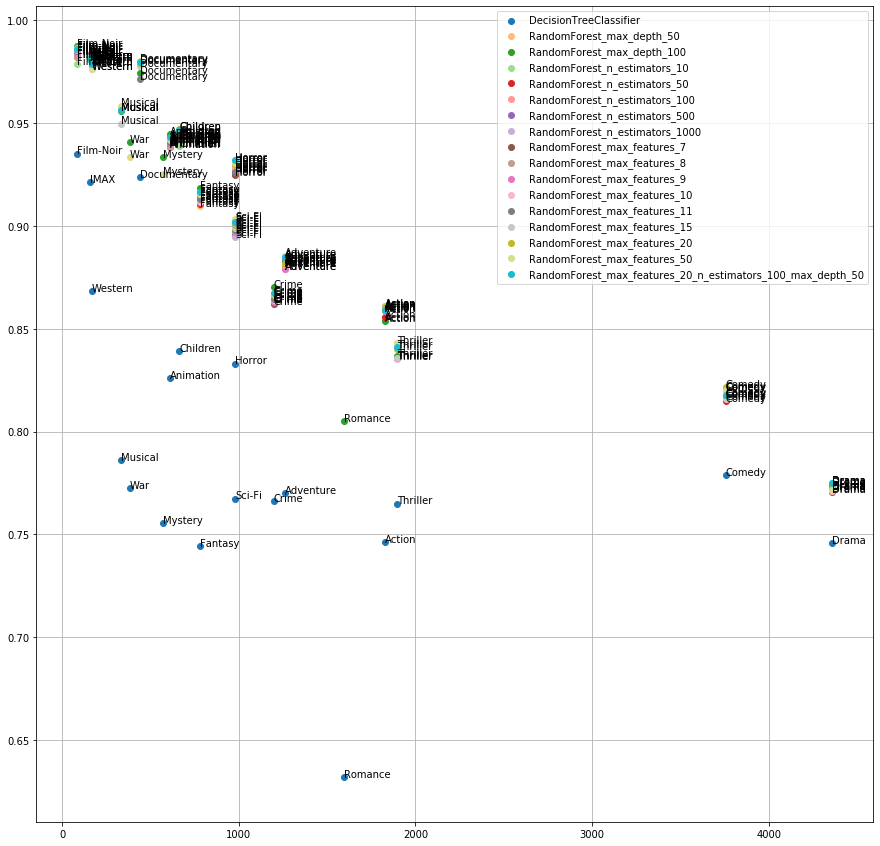

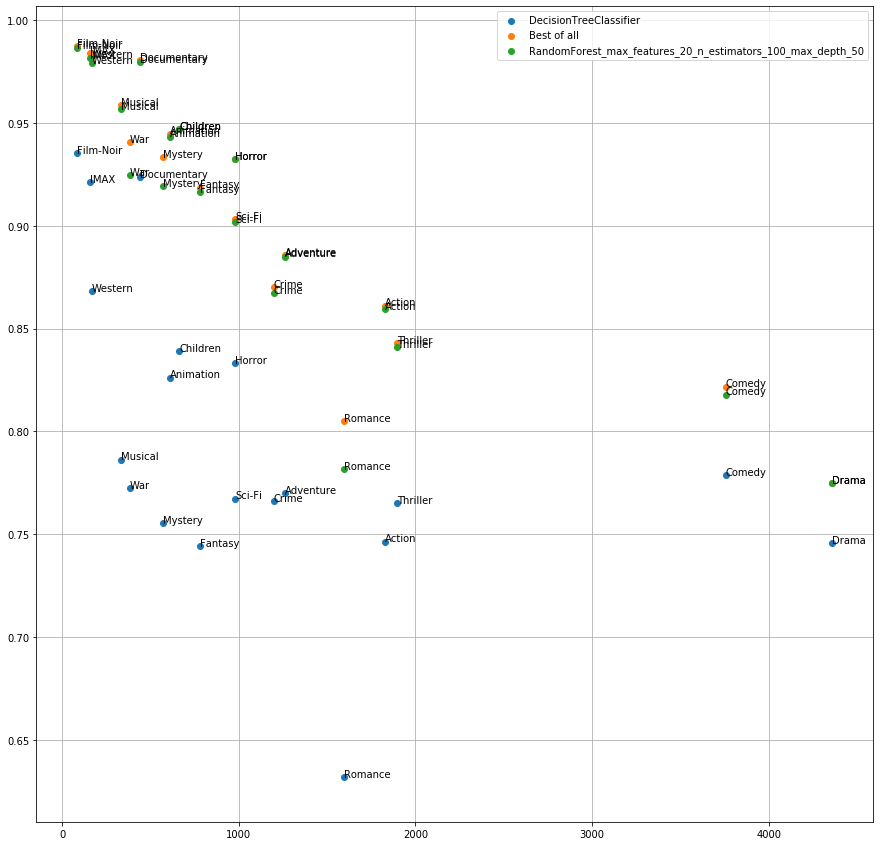

In [26]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('tab20')
best = {g:np.max([plot_data[test][g][1] for test in plot_data]) for g in genres}


for i, name in enumerate(plot_data):
    # if "max_depth" not in name and "max_features" not in name:
    if name != "DecisionTreeClassifier":
        chosen_data = {
            g: plot_data[name][g] 
            for g in plot_data[name] 
            if np.abs(plot_data[name][g][1] - best[g]) / best[g] < 0.01
        }

    else:
        chosen_data = plot_data[name]
    color = cmap(i/len(plot_data))
    if len(chosen_data) > 0:
        plot_results(chosen_data, axs, name, color=[color])
    else:
        print(name)

axs[1].legend()
axs[1].grid(True)

best_cls = {
    g: sorted(
        [
            (name, plot_data[name][g][1])
            for name in plot_data 
            if np.abs(plot_data[name][g][1] - best[g]) / best[g] < 0.01
        ], 
        key=lambda x: x[1]
    )[::-1]
    for g in genres
}
print(Counter(
    [c[0]
        for  g in best_cls
        for c in best_cls[g]
    ]
))
plt.show()

axs = plt.subplots(figsize=(15, 15))
plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(
    {
        g: [plot_data["DecisionTreeClassifier"][g][0], best_cls[g][0][1]]
        for g in best_cls
    }, axs, "Best of all"
)
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")
axs[1].legend()
axs[1].grid(True)

plt.show()


In [11]:
from datetime import datetime
with open(f'backup/plot_data_dump_{datetime.now()}.pickle', 'wb') as handle:
    pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

for i in tqdm([5, 10, 50, 100]):
    name = f"RandomForestRegressor_max_depth_{i}"
    plot_data[name]=test_classifier(
            RandomForestRegressor,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=i,
            random_state=7,
            max_features=5,
            n_estimators=100,
            n_jobs=4,
#             class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



for i in tqdm([10, 50, 100, 500, 1000]):
    name = f"RandomForestRegressor_n_estimators_{i}"
    plot_data[name]=test_classifier(
            RandomForestRegressor,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=9,
            n_estimators=i,
            n_jobs=4,
#             class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
for i in tqdm([7, 8, 9, 10, 11, 15, 20, 50]):
    name = f"RandomForestRegressor_max_features_{i}"
    plot_data[name]=test_classifier(
            RandomForestRegressor,
            Tree_data,
            tmp_genres,
            clf_name=name,
            axs=axs,
            verbose=False,
            plot=False,
            max_depth=50,
            random_state=7,
            max_features=i,
            n_jobs=4,
            n_estimators=100,
#             class_weight="balanced"
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



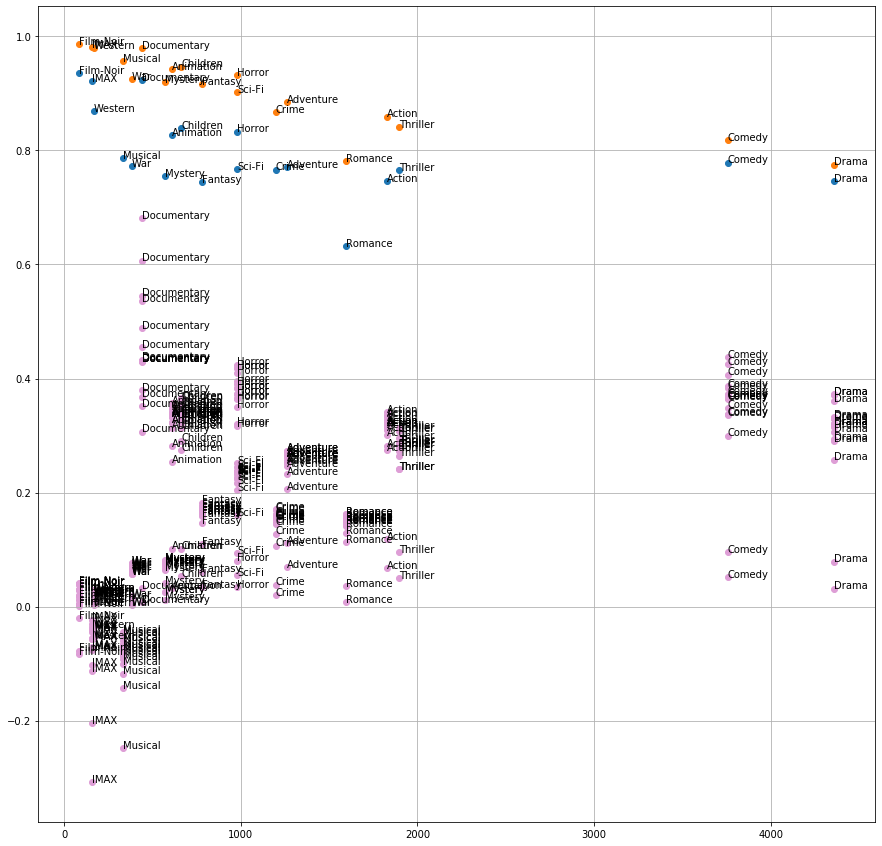

In [39]:
axs = plt.subplots(figsize=(15, 15))
cmap = matplotlib.cm.get_cmap('tab20b')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")


for i, name in enumerate(plot_data):
    if "RandomForestRegressor" in name:
        color = cmap(i/20.)
        plot_results(plot_data[name], axs, name, color=[color])


# axs[1].legend()
axs[1].grid(True)

In [ ]:
for alpha in tqdm([0.1, 0.5, 0.7, 0.9, 1, 1.5, 2, 5, 10, 100]):
    for fit_prior in [True, False]:
        name = f"MultinomialNB_alpha_{alpha}_fit_prior_{fit_prior}"
        plot_data[name]=test_classifier(
                MultinomialNB,
                Tree_data,
                tmp_genres,
                clf_name=name,
                axs=axs,
                verbose=False,
                plot=False,
                alpha= alpha,
                fit_prior=fit_prior
        )
        with open('plot_data.pickle', 'wb') as handle:
            pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
for alpha in tqdm([150, 500, 1000, 5000, 20000]):
    for fit_prior in [True, False]:
        name = f"MultinomialNB_alpha_{alpha}_fit_prior_{fit_prior}"
        plot_data[name]=test_classifier(
                MultinomialNB,
                Tree_data,
                tmp_genres,
                clf_name=name,
                axs=axs,
                verbose=False,
                plot=False,
                alpha= alpha,
                fit_prior=fit_prior
        )
        with open('plot_data.pickle', 'wb') as handle:
            pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)





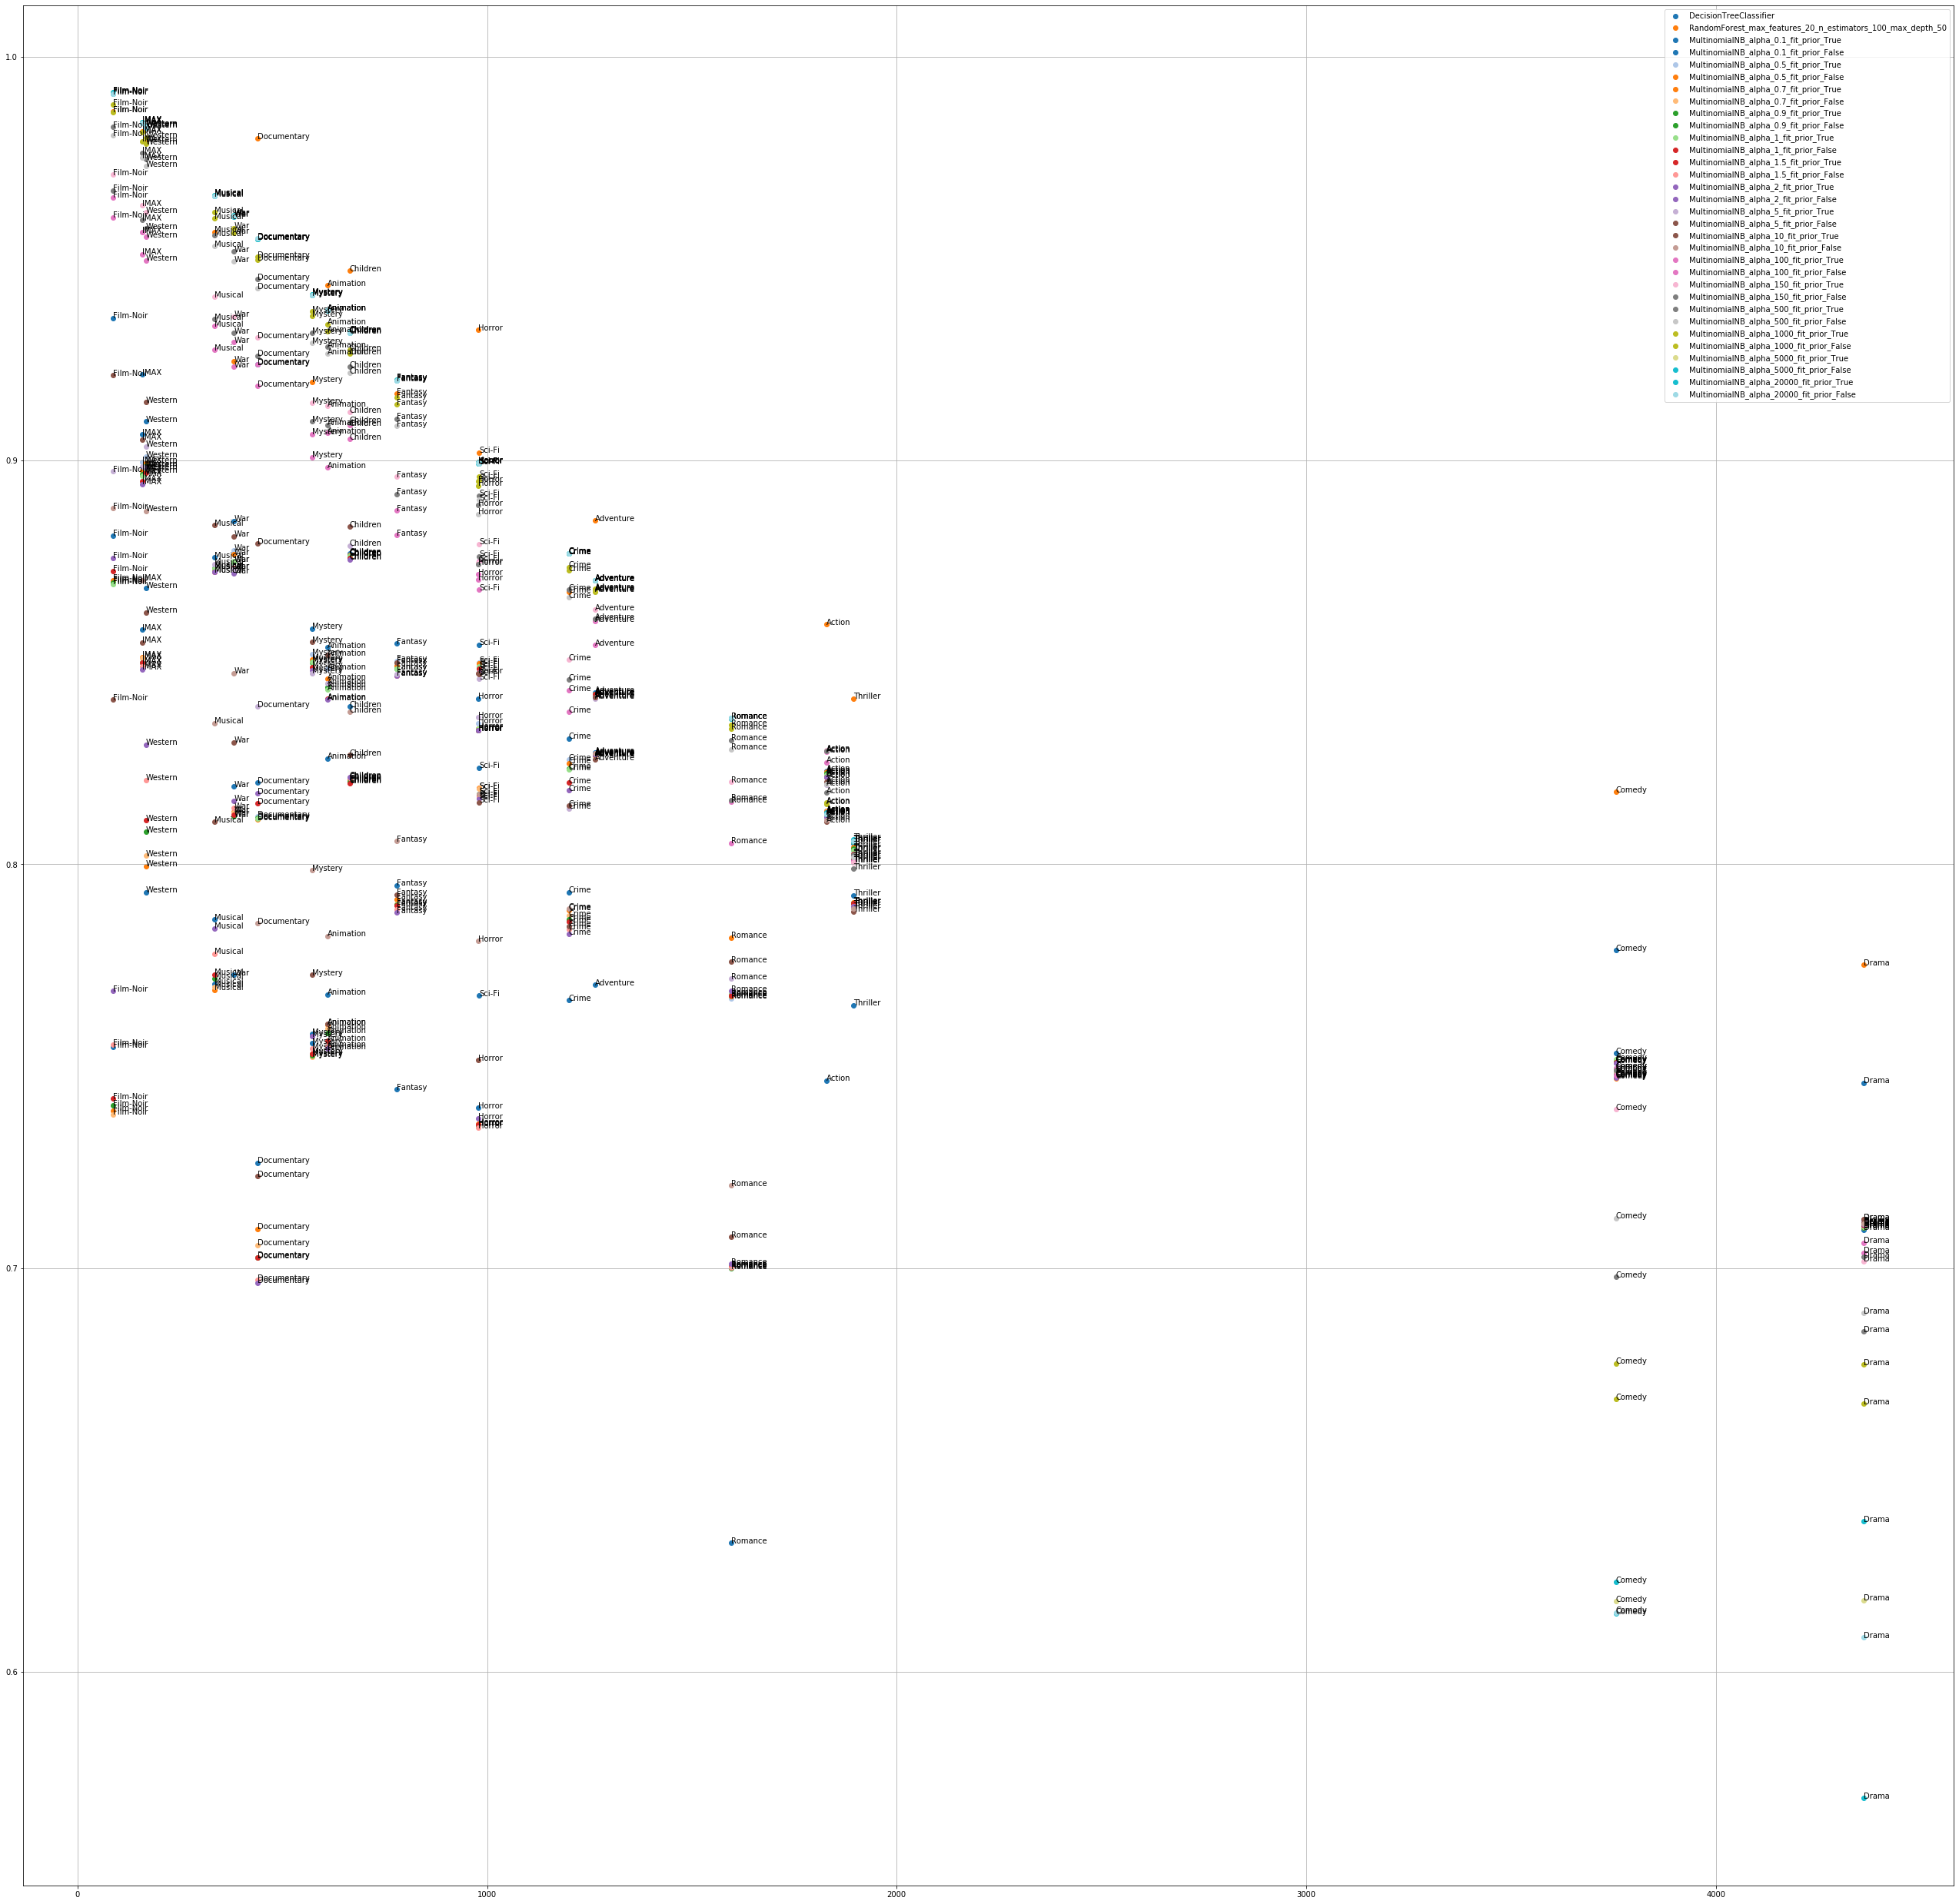

In [51]:
axs = plt.subplots(figsize=(45, 45))
cmap = matplotlib.cm.get_cmap('tab20')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")

nb_plot_data = {k: plot_data[k] for k in plot_data if "MultinomialNB" in k}
for i, name in enumerate(nb_plot_data):
    color = cmap(i/len(nb_plot_data))
    plot_results(nb_plot_data[name], axs, name, color=[color])


axs[1].legend()
axs[1].grid(True)

In [ ]:
tmp_genres = list(genres)
for learning_rate in [0.1, 0.5, 0.9, 1., 1.5, 5, 10, 50]:
    name = f"AdaBoost_learning_rate_{learning_rate}"
    plot_data[name]=test_classifier(
        AdaBoostClassifier,
        Tree_data,
        tmp_genres,
        clf_name=name,
        verbose=False,
        plot=False,
        cv_n_jobs=-1,
        random_state=7,
        learning_rate=learning_rate
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

for n_estimators in [5, 10, 50, 100, 500, 1000]:
    name = f"AdaBoost_n_estimators_{n_estimators}"
    plot_data[name]=test_classifier(
        AdaBoostClassifier,
        Tree_data,
        tmp_genres,
        clf_name=name,
        verbose=False,
        plot=False,
        cv_n_jobs=-1,
        random_state=7,
        n_estimators=n_estimators
    )
    with open('plot_data.pickle', 'wb') as handle:
        pickle.dump(plot_data, handle, protocol=pickle.HIGHEST_PROTOCOL)






  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:46<13:56, 46.45s/it]

 11%|█         | 2/19 [01:31<13:00, 45.92s/it]

 16%|█▌        | 3/19 [02:15<12:06, 45.41s/it]

 21%|██        | 4/19 [02:58<11:13, 44.87s/it]

 26%|██▋       | 5/19 [03:42<10:22, 44.45s/it]

 32%|███▏      | 6/19 [04:26<09:34, 44.19s/it]

 37%|███▋      | 7/19 [05:09<08:47, 43.99s/it]

 42%|████▏     | 8/19 [05:52<08:01, 43.78s/it]

 47%|████▋     | 9/19 [06:36<07:16, 43.64s/it]

 53%|█████▎    | 10/19 [07:20<06:33, 43.73s/it]

 58%|█████▊    | 11/19 [08:03<05:48, 43.58s/it]

 63%|██████▎   | 12/19 [08:46<05:04, 43.44s/it]

 68%|██████▊   | 13/19 [09:29<04:19, 43.32s/it]

 74%|███████▎  | 14/19 [10:12<03:36, 43.21s/it]

 79%|███████▉  | 15/19 [10:55<02:52, 43.11s/it]

 84%|████████▍ | 16/19 [11:38<02:09, 43.04s/it]

 89%|████████▉ | 17/19 [12:21<01:25, 43.00s/it]

 95%|█████████▍| 18/19 [13:03<00:42, 42.94s/it]

100%|██████████| 19/19 [13:46<00:00, 42.91s/it]

  0%|          | 0/19 [00:00<?, ?it/

In [ ]:
axs = plt.subplots(figsize=(45, 45))
cmap = matplotlib.cm.get_cmap('tab20')

plot_results(plot_data["DecisionTreeClassifier"], axs, "DecisionTreeClassifier")
plot_results(plot_data["RandomForest_max_features_20_n_estimators_100_max_depth_50"], axs, "RandomForest_max_features_20_n_estimators_100_max_depth_50")

nb_plot_data = {k: plot_data[k] for k in plot_data if "AdaBoost" in k}
for i, name in enumerate(nb_plot_data):
    color = cmap(i/len(nb_plot_data))
    plot_results(nb_plot_data[name], axs, name, color=[color])


axs[1].legend()
axs[1].grid(True)

Unused staff

In [14]:
# x = np.array((utility_matrix.T @ utility_matrix).sum(axis=0)[:, movies["movieId"]])[0]
# for g in genres:
#     fig, ax = plt.subplots()
#     plt.title(g)
#     scatter = ax.scatter(x, x, c = movies[g])
#     legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower right", title="Classes")
#     ax.add_artist(legend1)
#     plt.show()
# 

In [15]:
# plt.figure(figsize=(10,600))
# plt.imshow(utility_matrix.toarray()[:, movies["movieId"]].T)
# 

In [16]:
# pca_model = PCA(n_components=2)
# pca = pca_model.fit_transform(utility_matrix.toarray()[:, movies["movieId"]].T)
# for g in genres:
#     fig, ax = plt.subplots()
#     plt.title(g)
#     scatter = ax.scatter(pca[:, 0], pca[:, 1], c = movies[g])
#     legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper right", title="Classes")
#     ax.add_artist(legend1)
#     plt.show()

In [17]:
# clf = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, utility_matrix.toarray()[:, movies["movieId"]].T, movies["Action"], cv=10)
# export_tree(clf, range(X.shape[1]), "cross_val.pdf")

In [ ]:
# clf = tree.DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_samples_leaf=10, )
# clf = clf.fit(Tree_data.drop(genres, axis=1), y)
# print(clf.score(Tree_data.drop(genres, axis=1), y))
# export_tree(clf, Tree_data.drop(genres, axis=1).columns, "custom2.pdf")



